In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [3]:
import glob
import gc

import torch
import xarray as xr
from neuralhydrology.nh_run import start_run, eval_run
from scripts.file_manipulator import file_rewriter

from pathlib import Path
import geopandas as gpd

import random
random.seed(42)
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
ts_dir = Path('../geo_data/time_series')

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Run for different configs


#### ERA5 precipitation

##### train

In [ ]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5', 't_min_e5', 'prcp_e5'])

if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/era5_static_qmm.yml"))


##### test

In [ ]:
run_dir = Path("./runs_q_mm/era5_prcp_0404_074943/")
eval_run(run_dir=run_dir, period="test")

#### ERA5-Land precipitation

##### train

In [ ]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/era5L_static_qmm.yml"))

##### test

In [ ]:
run_dir = Path("./runs_static/era5L_static_prcp_0704_170903/")
eval_run(run_dir=run_dir, period="test", epoch=21)

#### GPCP precipitation

##### train

In [ ]:
# gpcp
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5', 't_min_e5', 'prcp_gpcp'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/gpcp_static_qmm.yml"))
gc.collect()

##### test

In [ ]:
run_dir = Path("./runs_q_cms/gpcp_prcp_3003_063422")
eval_run(run_dir=run_dir, period="test")

#### IMERG precipitation

##### train

In [ ]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5', 't_min_e5', 'prcp_imerg'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/imerg_static_qmm.yml"))
gc.collect()


##### test

In [ ]:
run_dir = Path("./runs_q_cms/imerg_prcp_3003_135405")
eval_run(run_dir=run_dir, period="test")

#### MSWEP precipitation

##### train

In [ ]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5', 't_min_e5', 'prcp_mswep'])
if torch.cuda.is_available():
    start_run(config_file=Path("./no_static_configs/mswep_qmm.yml"))
gc.collect()

##### static run

In [15]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_mswep'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/mswep_static_qmm.yml"))
gc.collect()

2023-04-10 15:01:43,510: Logging to runs_static/mswep_static_prcp_1004_150143/output.log initialized.
2023-04-10 15:01:43,510: ### Folder structure created at runs_static/mswep_static_prcp_1004_150143
2023-04-10 15:01:43,511: ### Run configurations for mswep_static_prcp
2023-04-10 15:01:43,511: experiment_name: mswep_static_prcp
2023-04-10 15:01:43,511: run_dir: runs_static/mswep_static_prcp_1004_150143
2023-04-10 15:01:43,512: train_basin_file: openf_basins.txt
2023-04-10 15:01:43,512: validation_basin_file: openf_basins.txt
2023-04-10 15:01:43,512: test_basin_file: openf_basins.txt
2023-04-10 15:01:43,513: train_start_date: 2009-01-01 00:00:00
2023-04-10 15:01:43,513: train_end_date: 2016-12-31 00:00:00
2023-04-10 15:01:43,513: validation_start_date: 2017-01-01 00:00:00
2023-04-10 15:01:43,514: validation_end_date: 2018-12-31 00:00:00
2023-04-10 15:01:43,514: test_start_date: 2019-01-01 00:00:00
2023-04-10 15:01:43,514: test_end_date: 2020-12-31 00:00:00
2023-04-10 15:01:43,515: per_

0

##### test

In [ ]:
run_dir = Path("./runs_q_cms/mswep_prcp_3103_073833")
eval_run(run_dir=run_dir, period="test")

#### Level

In [14]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_h/*.nc'),
              ts_dir=ts_dir,
              hydro_target='lvl_mbs',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/era5L_static_level_mbs.yml"))
gc.collect()

2023-04-10 06:37:06,279: Logging to runs_static/era5L_static_mbs_60_epoch_1004_063706/output.log initialized.
2023-04-10 06:37:06,279: ### Folder structure created at runs_static/era5L_static_mbs_60_epoch_1004_063706
2023-04-10 06:37:06,280: ### Run configurations for era5L_static_mbs_60_epoch
2023-04-10 06:37:06,280: experiment_name: era5L_static_mbs_60_epoch
2023-04-10 06:37:06,281: run_dir: runs_static/era5L_static_mbs_60_epoch_1004_063706
2023-04-10 06:37:06,281: train_basin_file: openf_basins.txt
2023-04-10 06:37:06,281: validation_basin_file: openf_basins.txt
2023-04-10 06:37:06,282: test_basin_file: openf_basins.txt
2023-04-10 06:37:06,282: train_start_date: 2009-01-01 00:00:00
2023-04-10 06:37:06,283: train_end_date: 2016-12-31 00:00:00
2023-04-10 06:37:06,283: validation_start_date: 2017-01-01 00:00:00
2023-04-10 06:37:06,283: validation_end_date: 2018-12-31 00:00:00
2023-04-10 06:37:06,283: test_start_date: 2019-01-01 00:00:00
2023-04-10 06:37:06,284: test_end_date: 2020-12-3

0

In [ ]:
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_h/*.nc'),
              ts_dir=ts_dir,
              hydro_target='lvl_sm',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])
if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/era5L_static_level_lvl_relative.yml"))
gc.collect()

### Blind forecast

In [ ]:
partial_gauges = gpd.read_file(
    '../geo_data/great_db/geometry/gauges_partial_q.gpkg')

In [ ]:
with open('./basins_test.txt', 'w') as the_file:
    for gauge_name in partial_gauges['gauge_id']:
        the_file.write(f'{int(gauge_name)}\n')
# add train
file_rewriter(q_pathes=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_concat/*.nc')
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(partial_gauges['gauge_id']):
        ds = xr.open_dataset(file)
        filename = file.split('/')[-1]
        try:
            ds = ds.drop('gauge_id')
            ds.to_netcdf(f'{ts_dir}/{filename}')
        except ValueError:
            continue
        

if torch.cuda.is_available():
    start_run(config_file=Path("./static_configs/era5L_static_blind.yml"))
gc.collect()

In [ ]:
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_concat/*.nc')
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(partial_gauges['gauge_id']):
        ds = xr.open_dataset(file)
        filename = file.split('/')[-1]
        try:
            ds = ds.drop('gauge_id')
            ds = ds.rename({'index': 'date'})
            ds.to_netcdf(f'{ts_dir}/{filename}')
        except ValueError:
            continue
# for gauge in partial_gauges['gauge_id']:
    
#     ds = xr.open_dataset(f'../geo_data/time_series/{gauge}.nc')
    
#     ds.to_netcdf(f'../geo_data/time_series/{gauge}.nc')
    
    

In [ ]:
run_dir = Path("./runs_static/era5L_static_prcp_0904_152029/")
eval_run(run_dir=run_dir, period="test", epoch=24)

### Bad regions

#### Kavkaz

In [11]:
gauges = gpd.read_file(
    '../paper_visualisation/poor_gauges/kavkaz.gpkg')
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_all_q/*.nc')
gauge_list = list()
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(gauges['gauge_id']):
        gauge_list.append(file)
        
# add train
file_rewriter(q_pathes=gauge_list,
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])

if torch.cuda.is_available():
    start_run(config_file=Path("./poor_perfom_configs/era5L_kavkaz_qmm.yml"))
gc.collect()

2023-04-10 06:04:54,170: Logging to runs_bad_regions/era5L_kavkaz_1004_060454/output.log initialized.
2023-04-10 06:04:54,171: ### Folder structure created at runs_bad_regions/era5L_kavkaz_1004_060454
2023-04-10 06:04:54,171: ### Run configurations for era5L_kavkaz
2023-04-10 06:04:54,171: experiment_name: era5L_kavkaz
2023-04-10 06:04:54,172: run_dir: runs_bad_regions/era5L_kavkaz_1004_060454
2023-04-10 06:04:54,172: train_basin_file: openf_basins.txt
2023-04-10 06:04:54,173: validation_basin_file: openf_basins.txt
2023-04-10 06:04:54,173: test_basin_file: openf_basins.txt
2023-04-10 06:04:54,173: train_start_date: 2009-01-01 00:00:00
2023-04-10 06:04:54,174: train_end_date: 2016-12-31 00:00:00
2023-04-10 06:04:54,174: validation_start_date: 2017-01-01 00:00:00
2023-04-10 06:04:54,174: validation_end_date: 2018-12-31 00:00:00
2023-04-10 06:04:54,175: test_start_date: 2019-01-01 00:00:00
2023-04-10 06:04:54,175: test_end_date: 2020-12-31 00:00:00
2023-04-10 06:04:54,175: per_basin_trai

/opt/conda/lib/python3.9/site-packages/neuralhydrology/datasetzoo/basedataset.py:460: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/torch/csrc/utils/tensor_new.cpp:230.)
  per_basin_target_stds = torch.tensor([np.nanstd(obs, axis=1)], dtype=torch.float32)


# Epoch 1: 100%|██████████| 274/274 [00:09<00:00, 28.06it/s, Loss: 0.0443]
2023-04-10 06:05:08,684: Epoch 1 average loss: 0.14049608622045412
# Epoch 2: 100%|██████████| 274/274 [00:09<00:00, 29.20it/s, Loss: 0.0867]
2023-04-10 06:05:18,069: Epoch 2 average loss: 0.05810246545903004
# Epoch 3: 100%|██████████| 274/274 [00:08<00:00, 30.46it/s, Loss: 0.0509]
2023-04-10 06:05:27,068: Epoch 3 average loss: 0.054747352838842536
# Validation: 100%|██████████| 24/24 [00:02<00:00,  9.32it/s]
2023-04-10 06:05:29,662: Stored results at runs_bad_regions/era5L_kavkaz_1004_060454/validation/model_epoch003/validation_results.p
2023-04-10 06:05:29,663: Epoch 3 average validation loss: 0.21241 -- Median validation metrics: NSE: -0.20049, KGE: -0.16853
# Epoch 4: 100%|██████████| 274/274 [00:09<00:00, 30.22it/s, Loss: 0.0405]
2023-04-10 06:05:38,733: Epoch 4 average loss: 0.05252450480921208
# Epoch 5: 100%|██████████| 274/274 [00:09<00:00, 28.86it/s, Loss: 0.0899]
2023-04-10 06:05:48,230: Epoch 5 aver

28

In [17]:
gauges = gpd.read_file(
    '../paper_visualisation/poor_gauges/volgo_don.gpkg')
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_all_q/*.nc')
gauge_list = list()
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(gauges['gauge_id']):
        gauge_list.append(file)
        
# add train
file_rewriter(q_pathes=gauge_list,
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


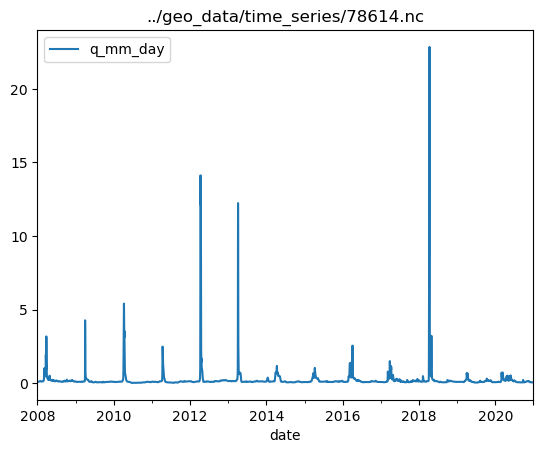

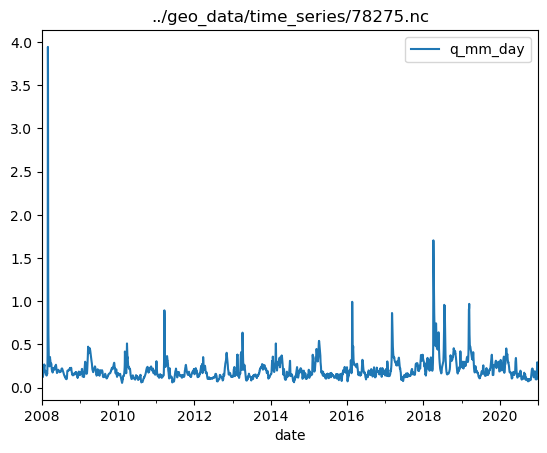

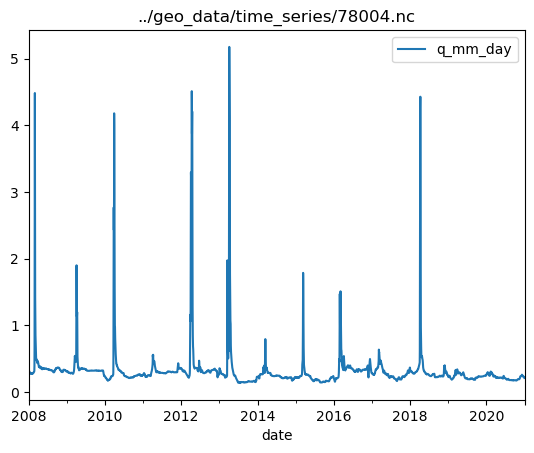

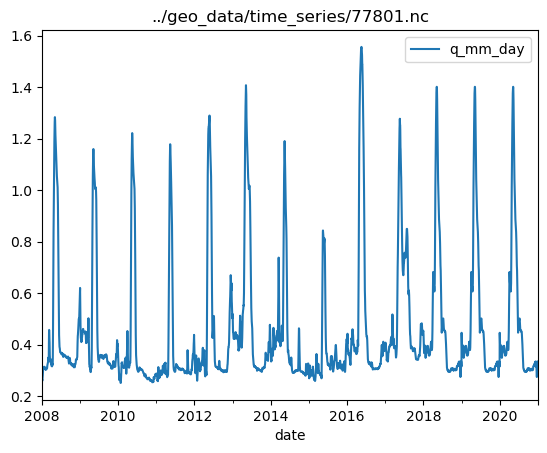

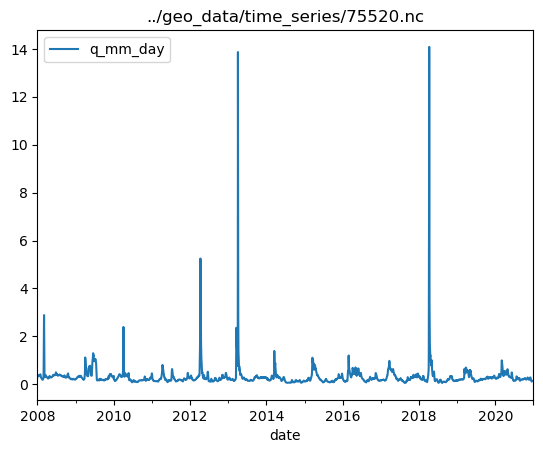

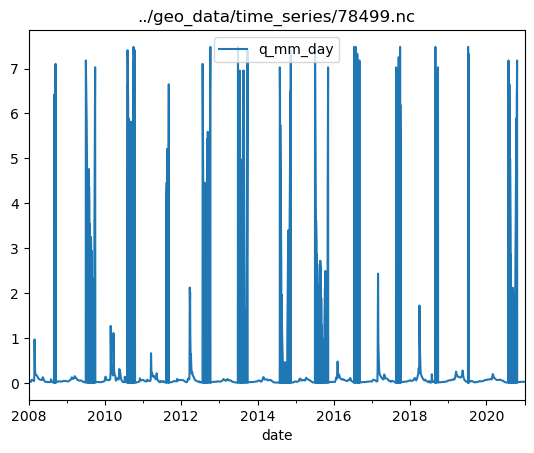

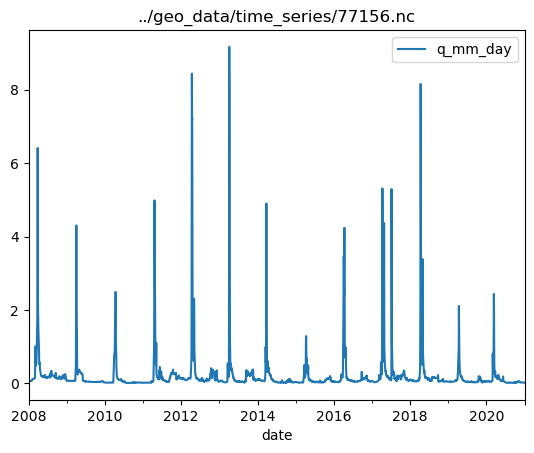

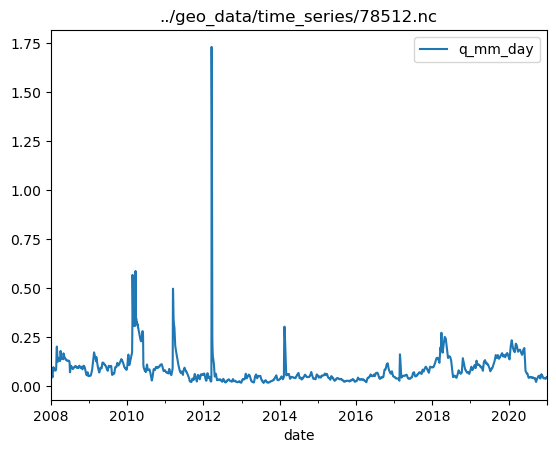

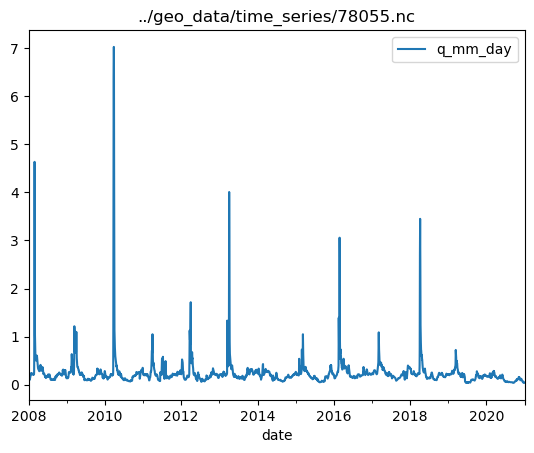

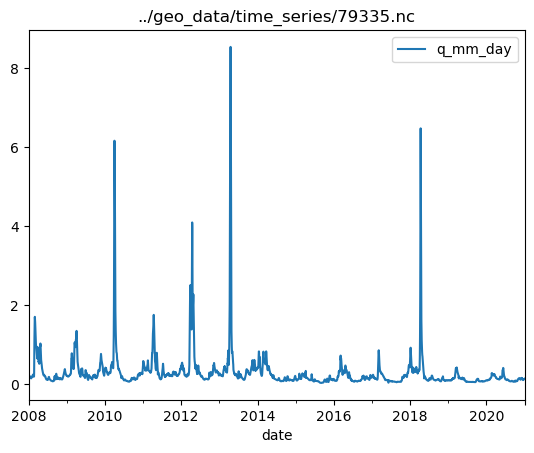

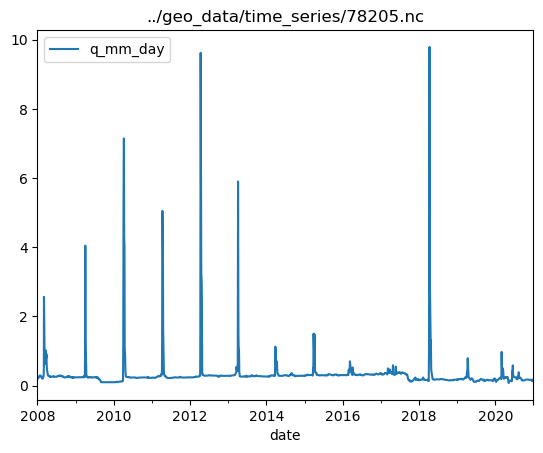

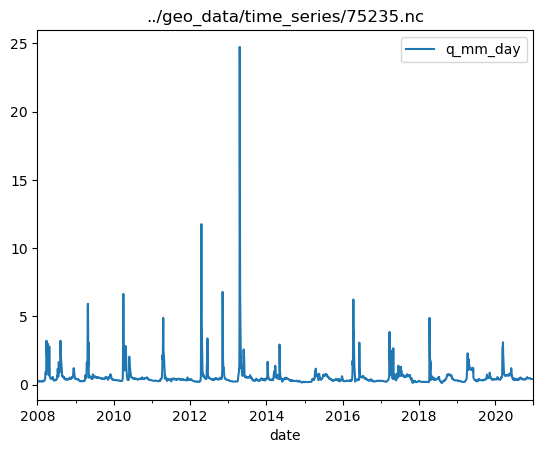

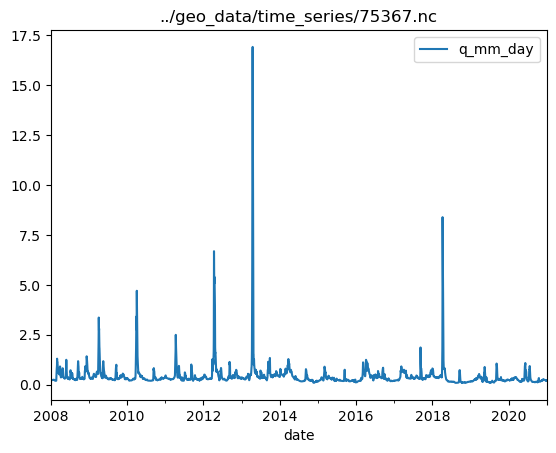

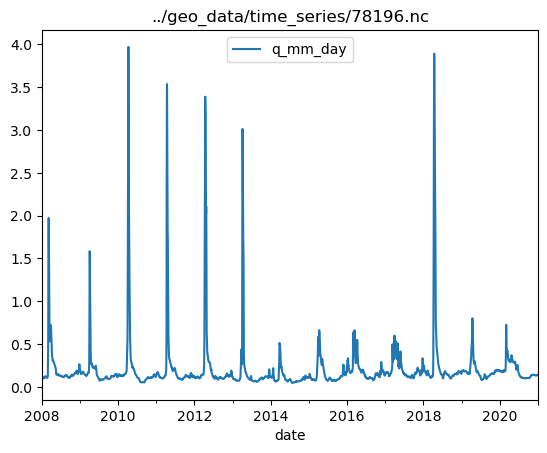

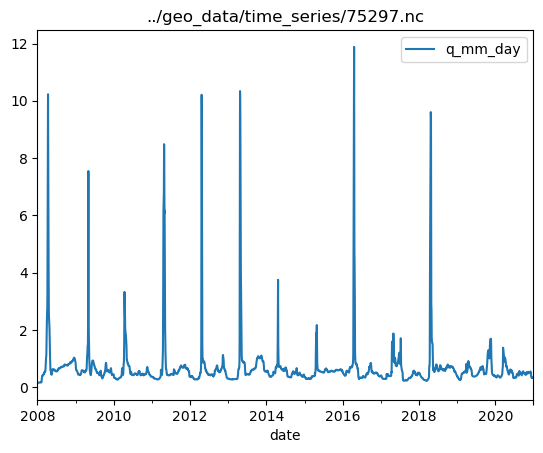

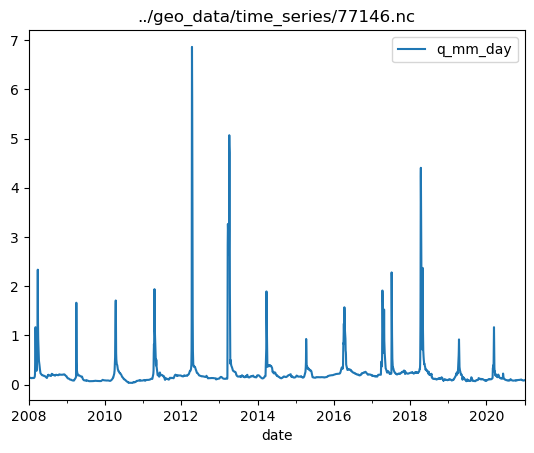

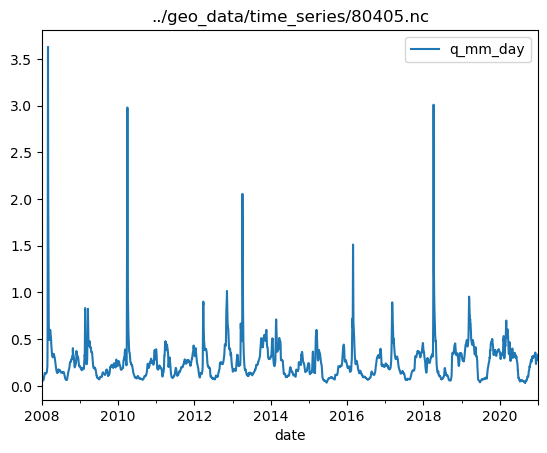

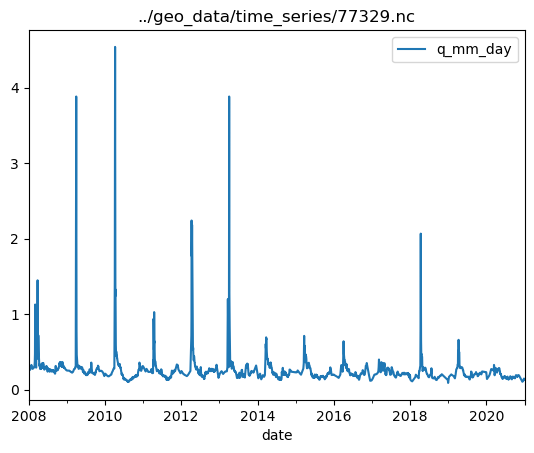

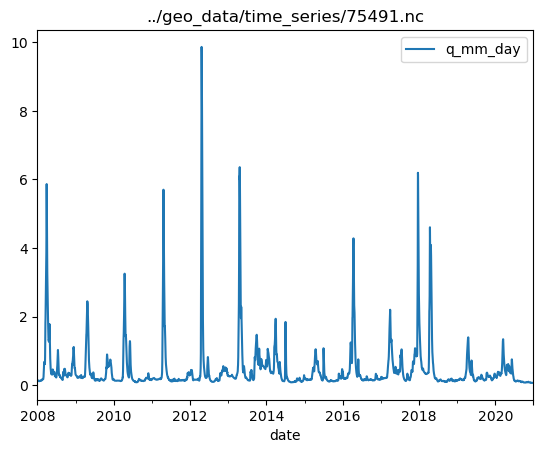

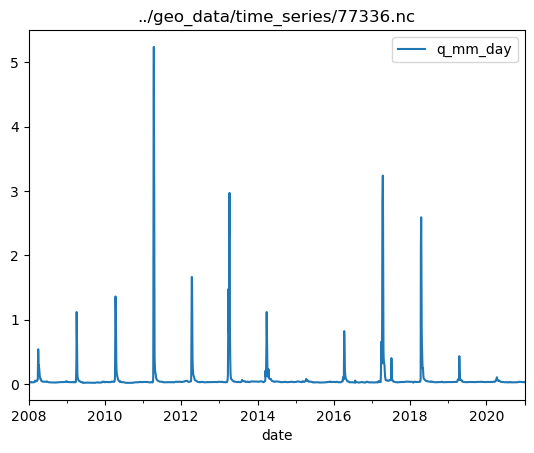

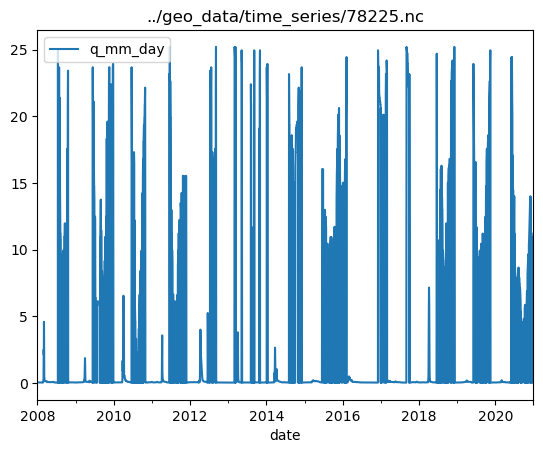

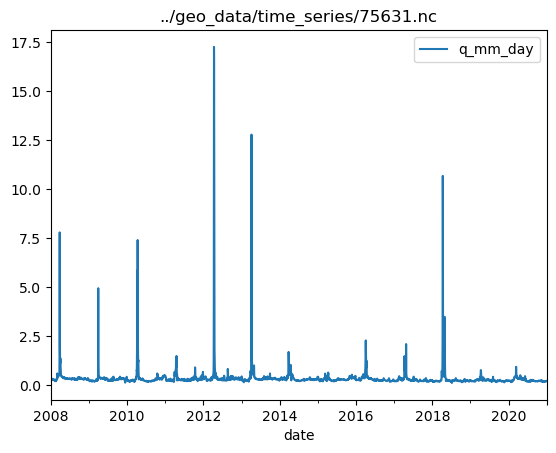

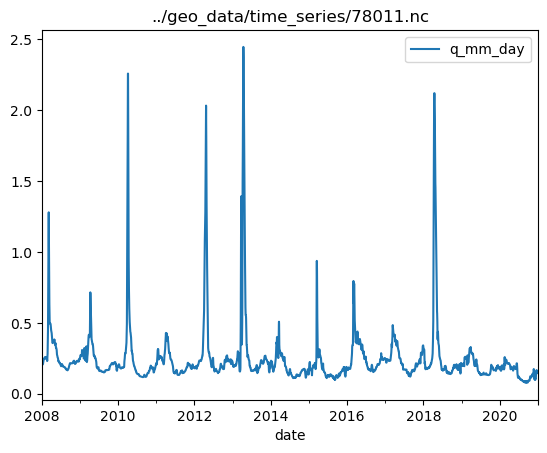

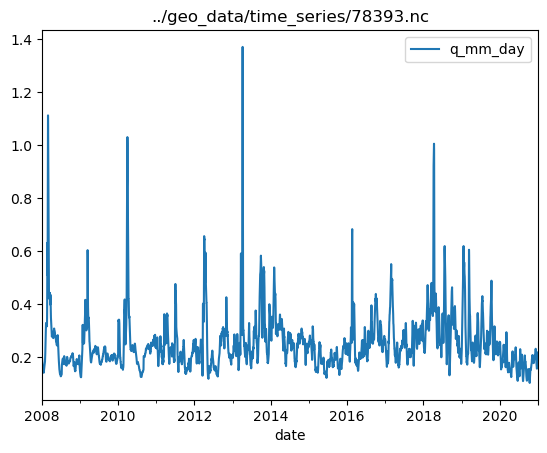

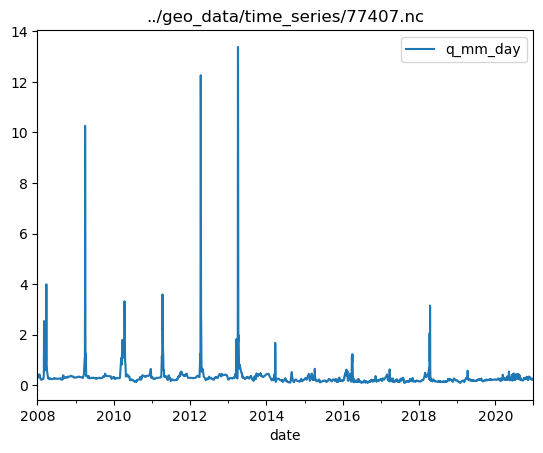

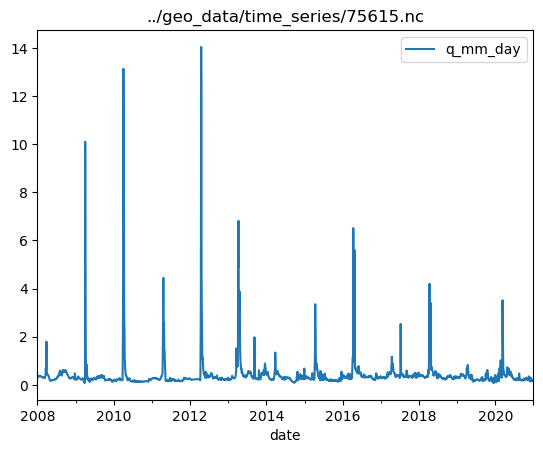

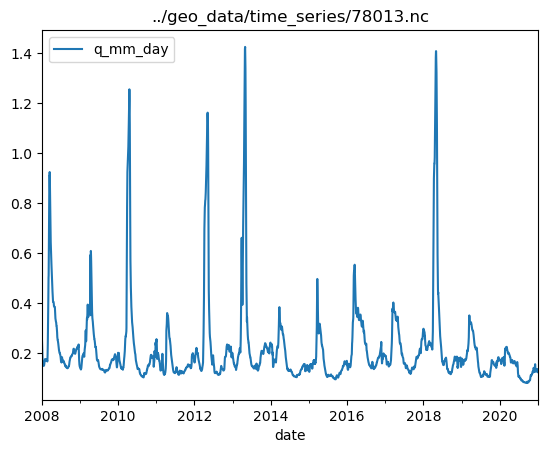

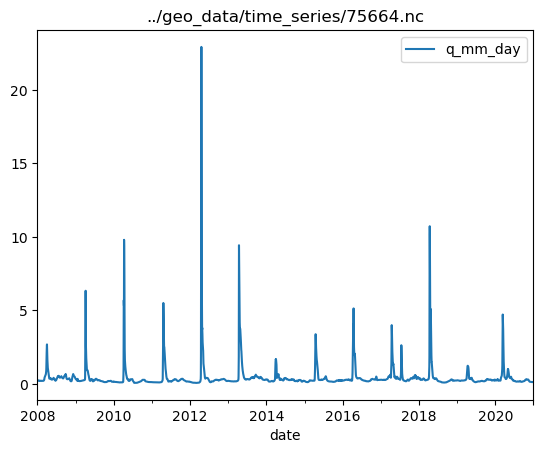

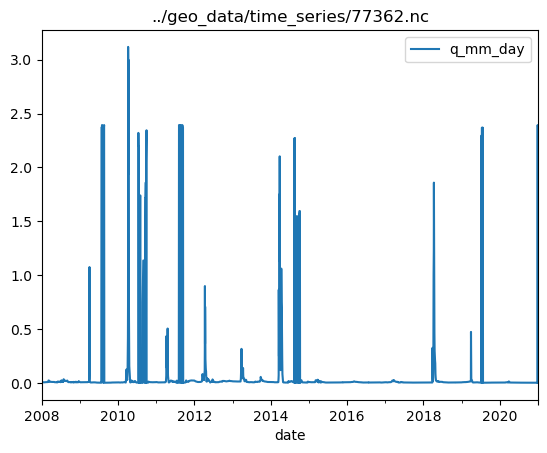

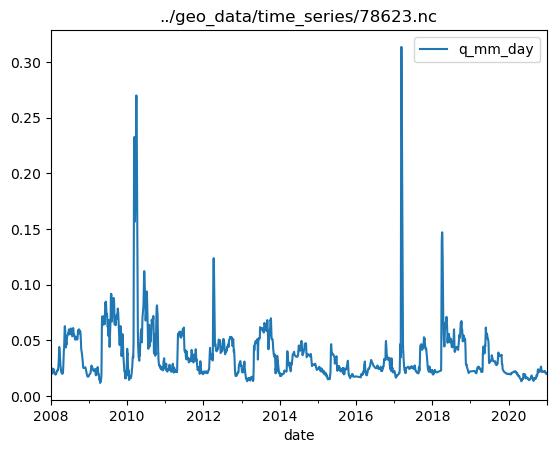

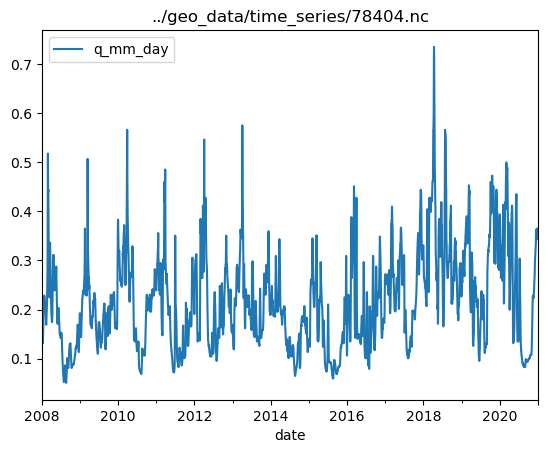

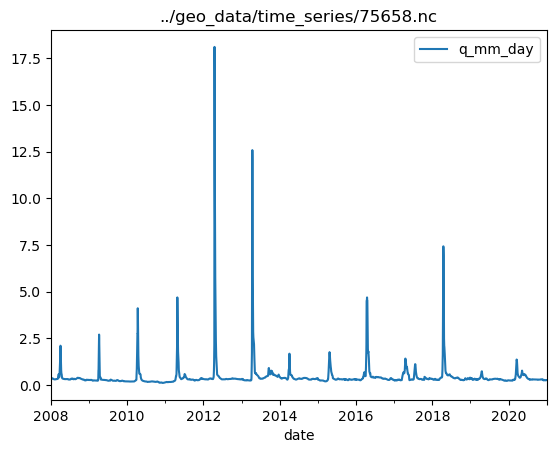

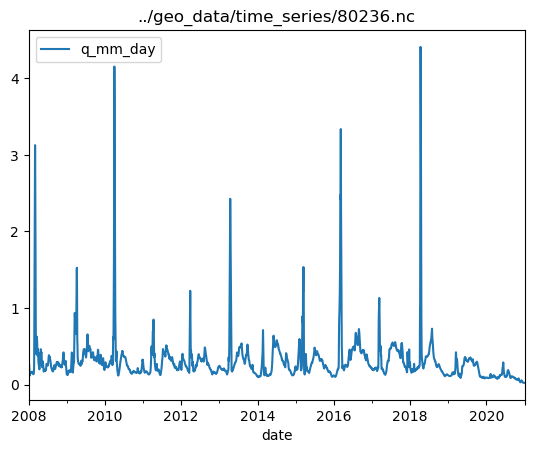

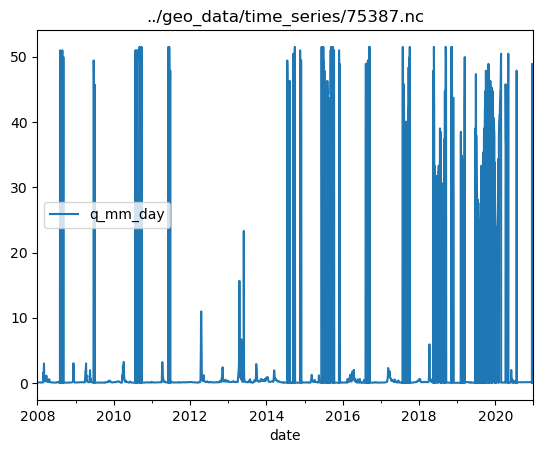

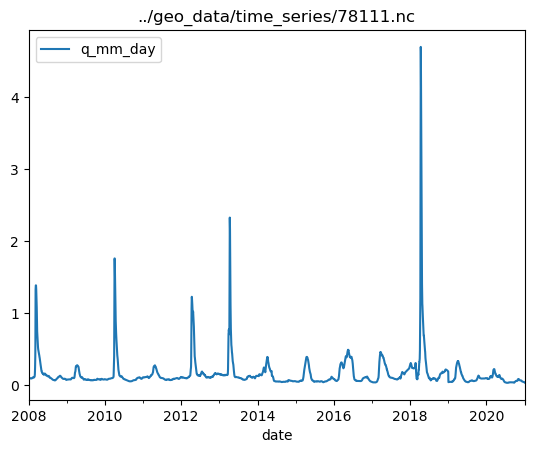

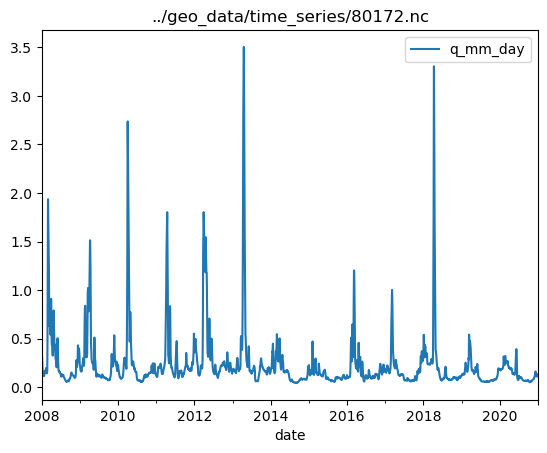

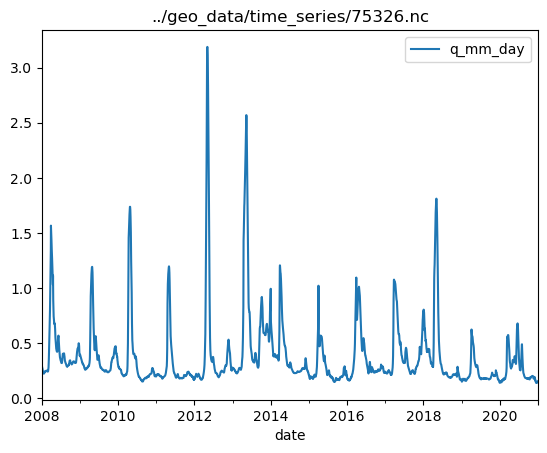

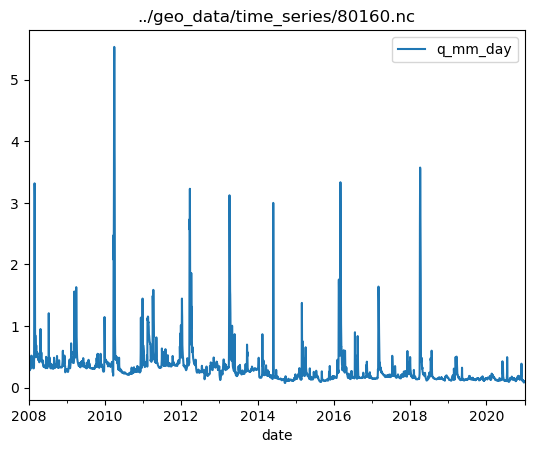

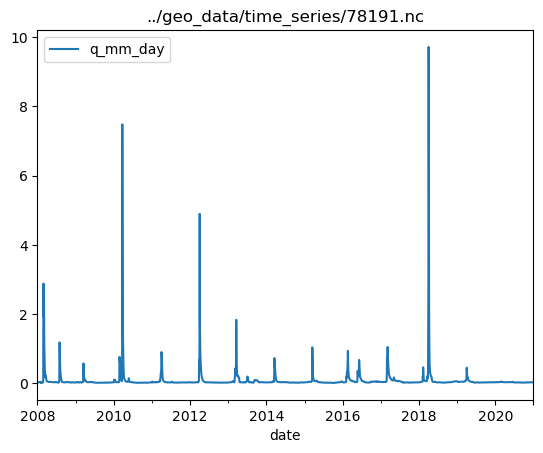

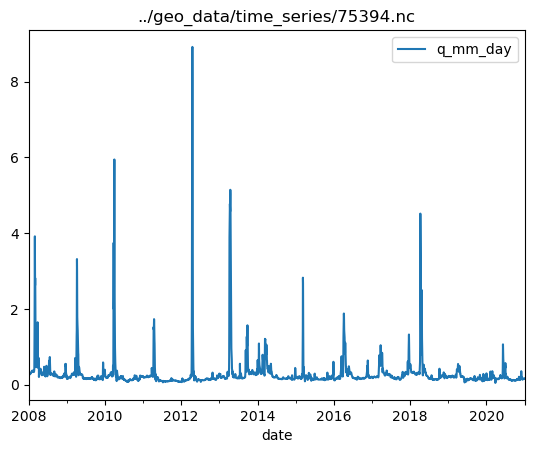

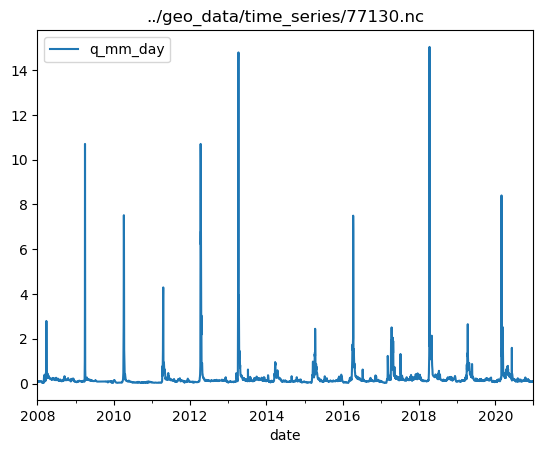

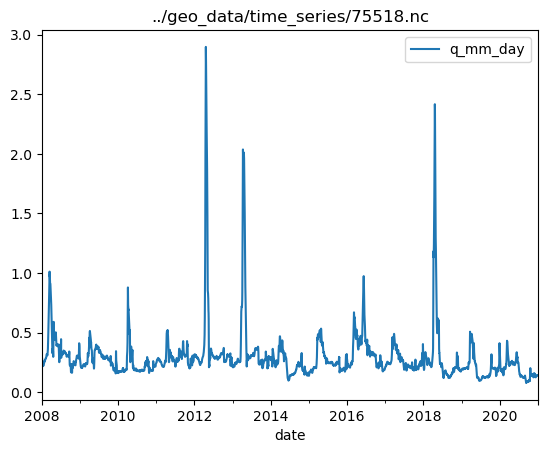

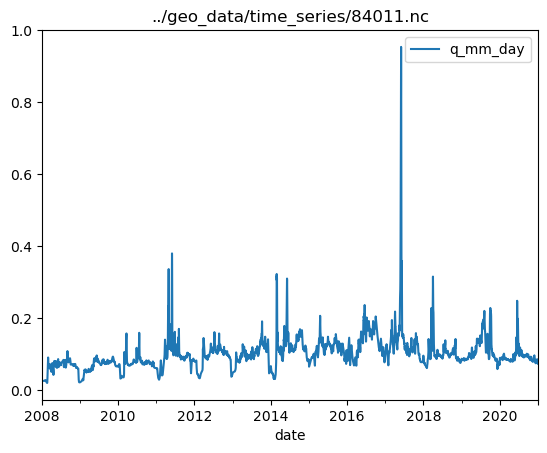

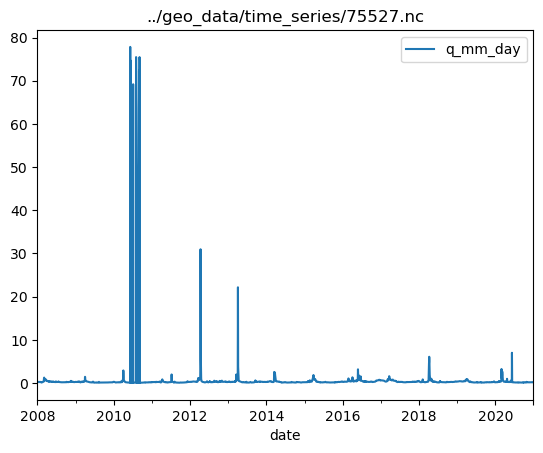

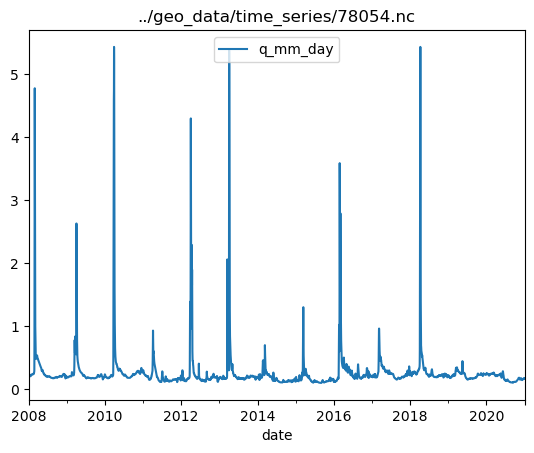

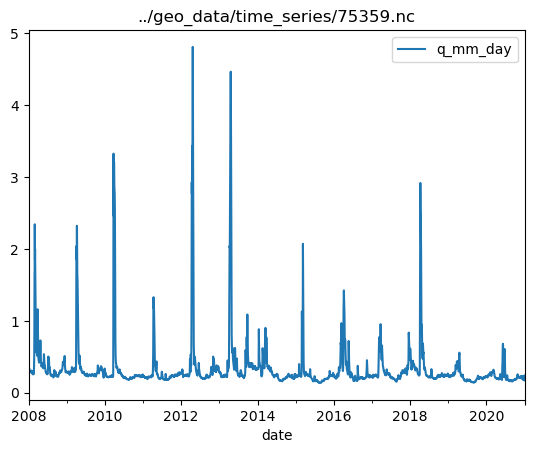

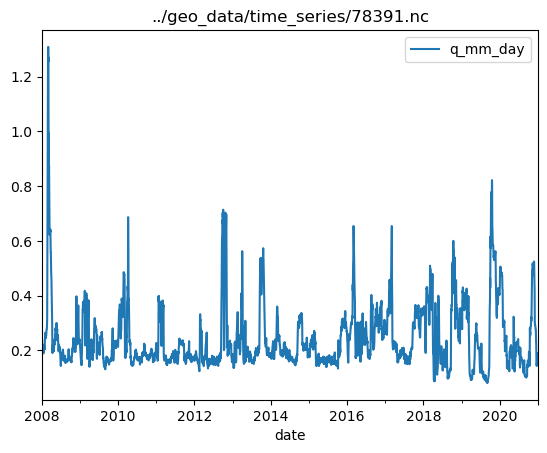

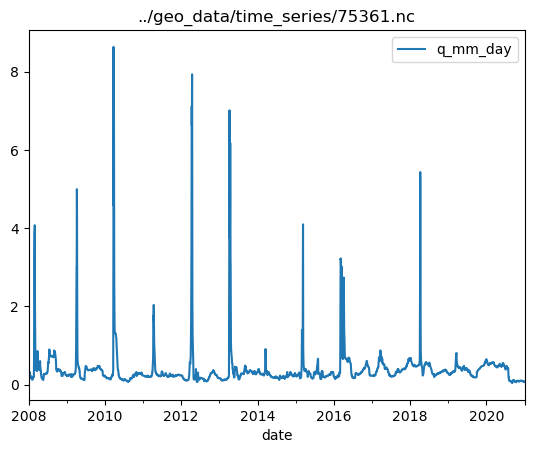

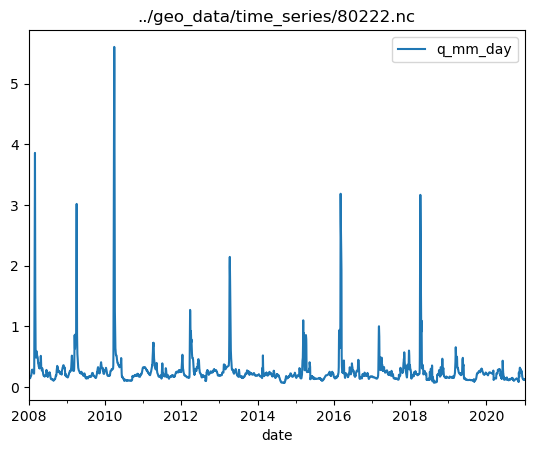

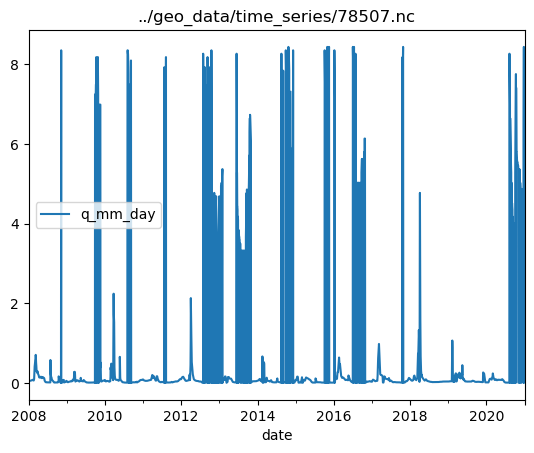

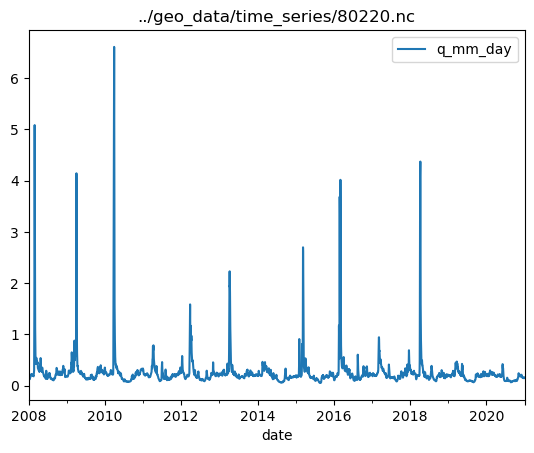

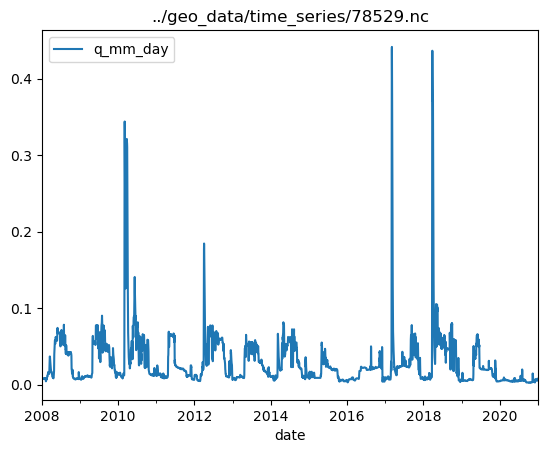

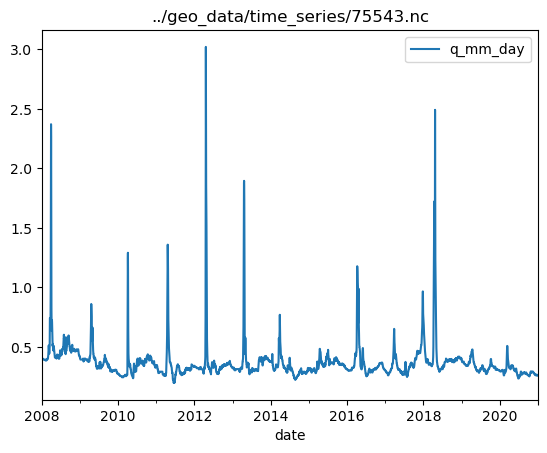

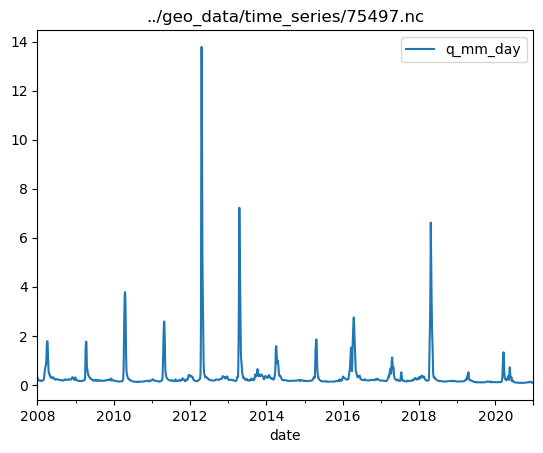

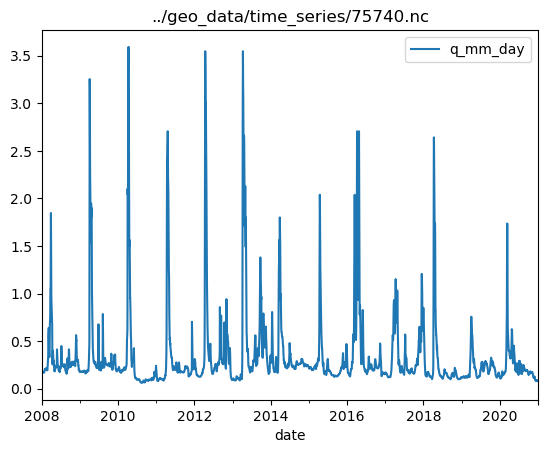

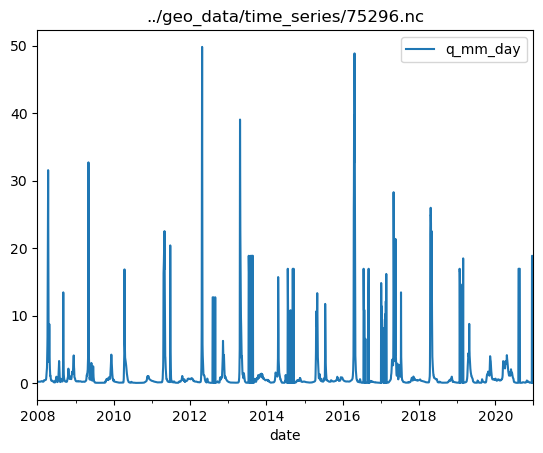

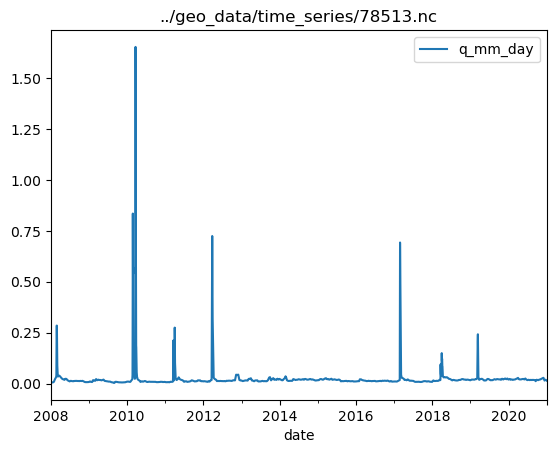

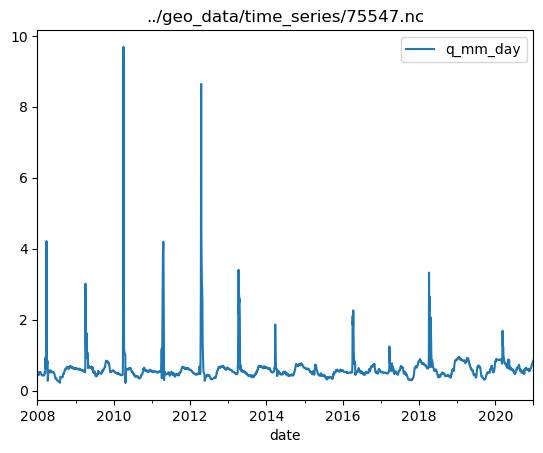

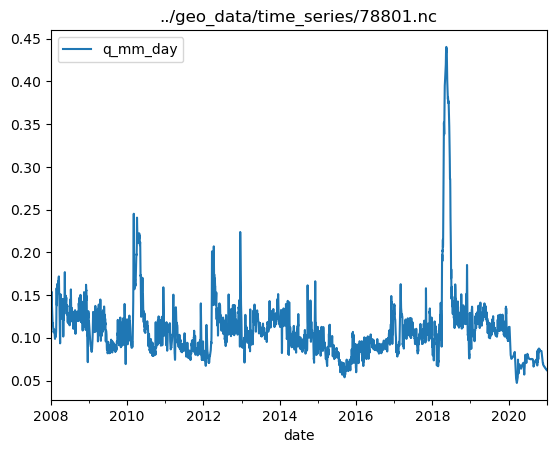

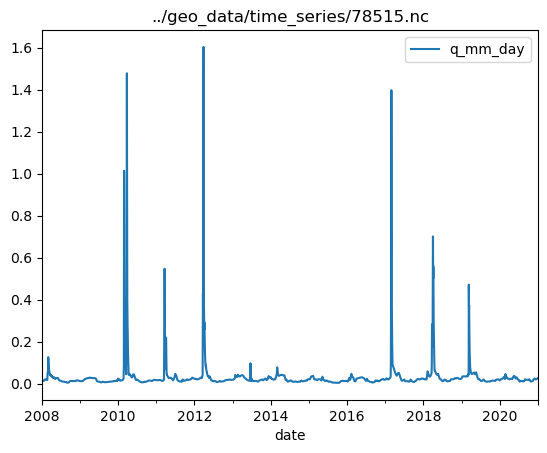

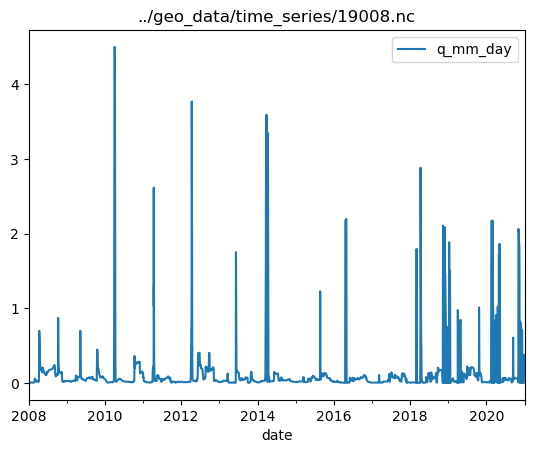

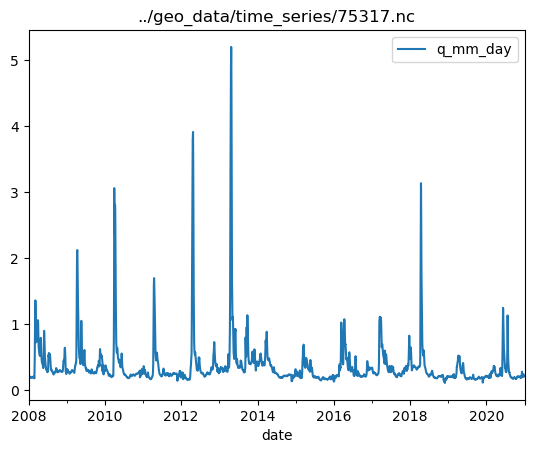

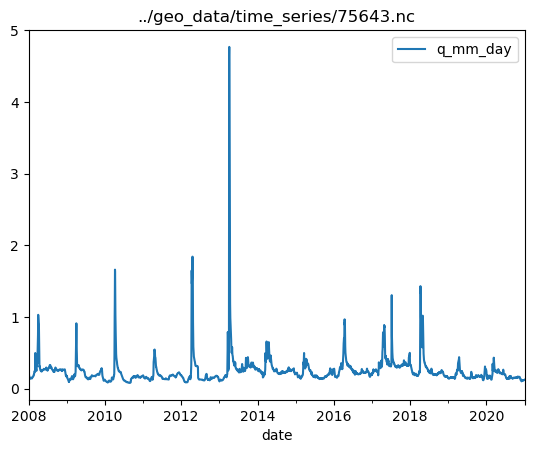

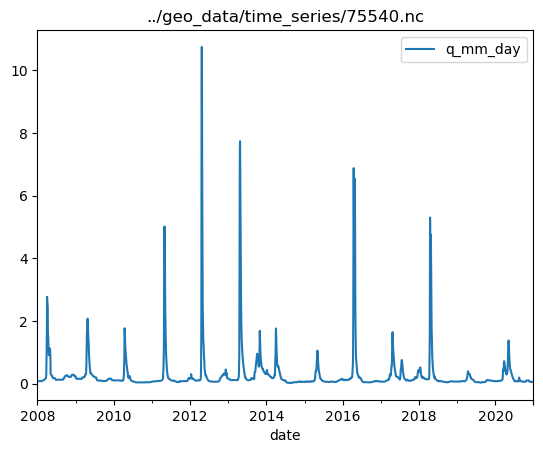

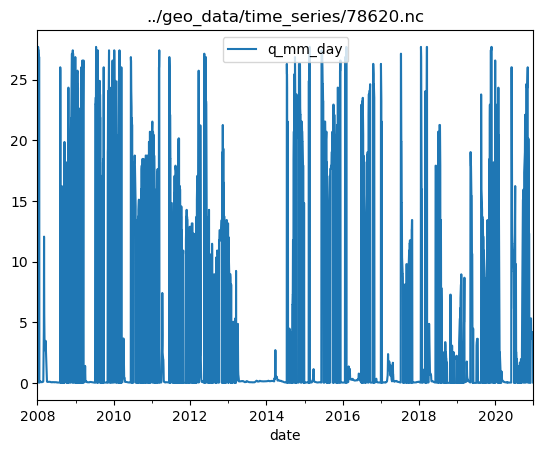

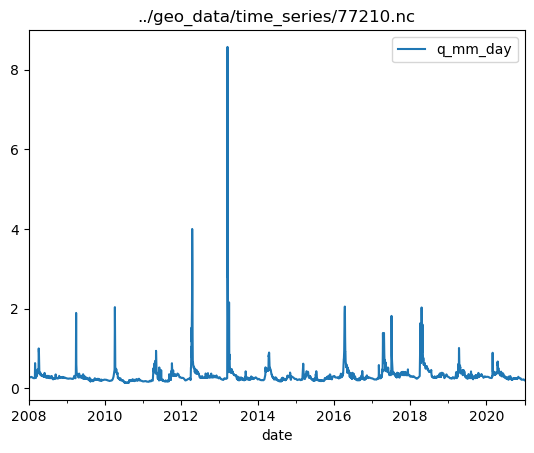

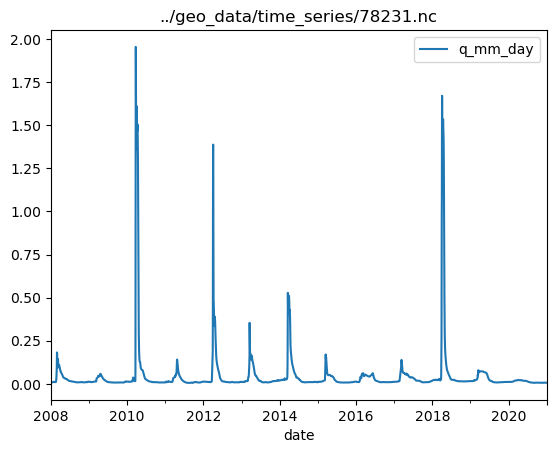

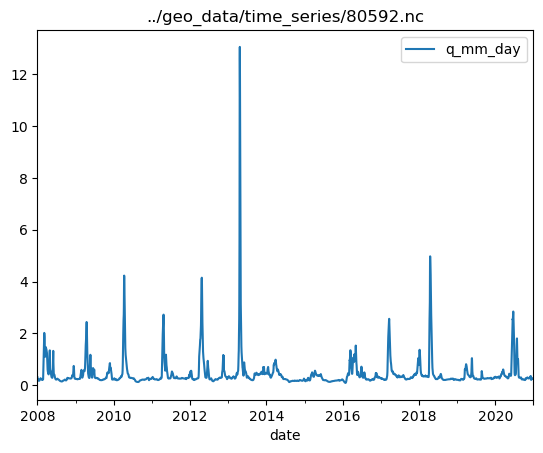

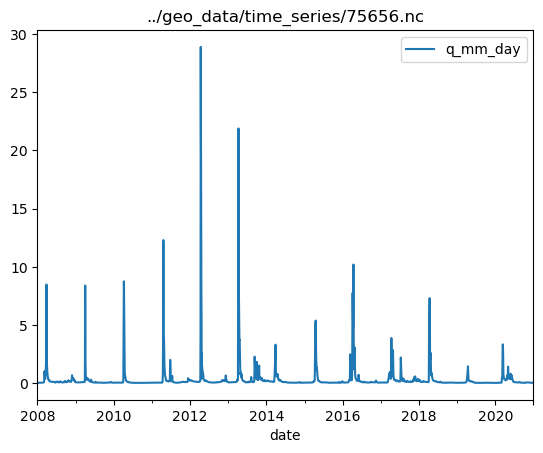

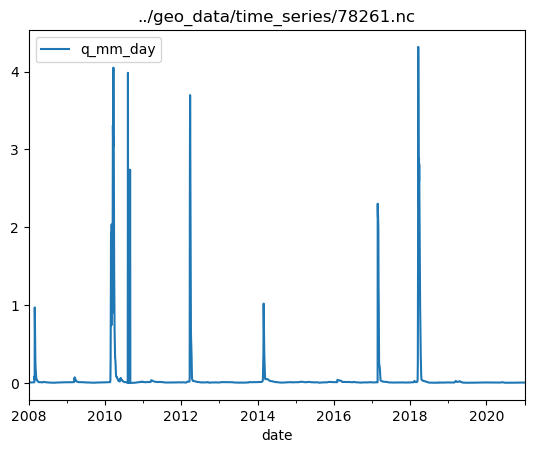

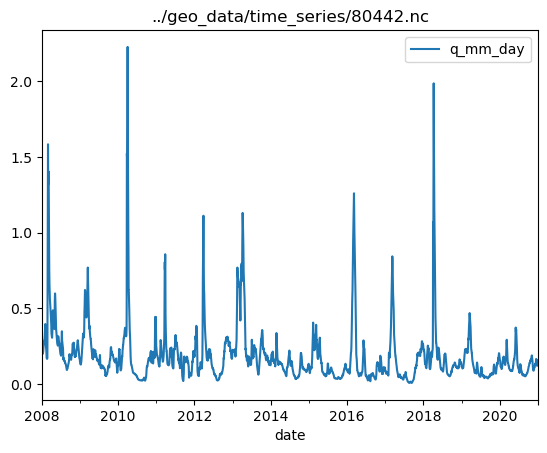

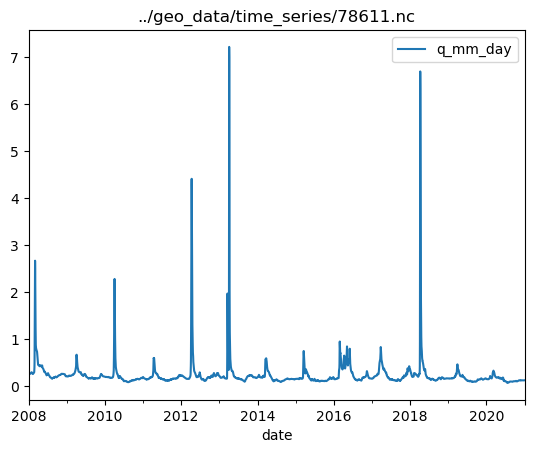

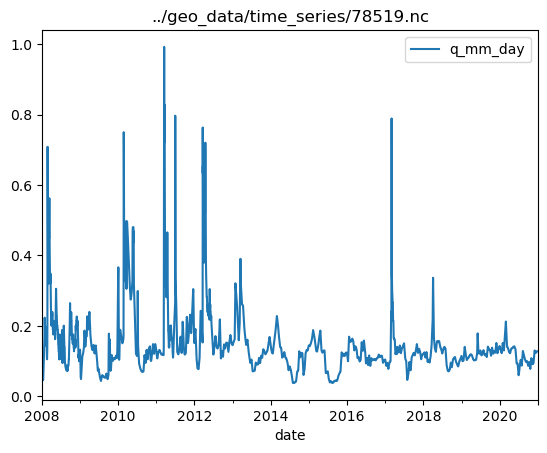

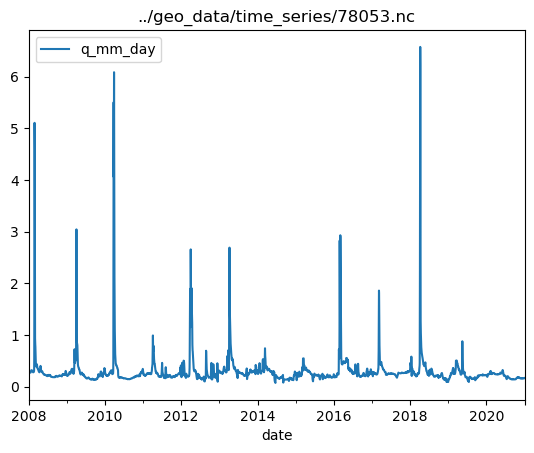

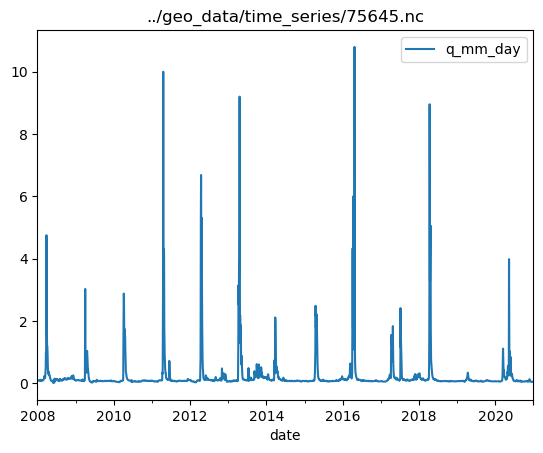

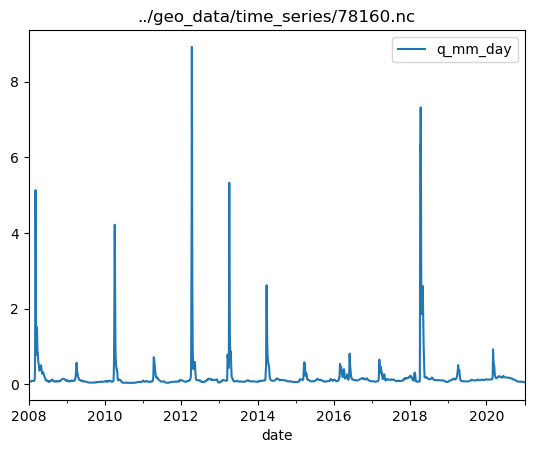

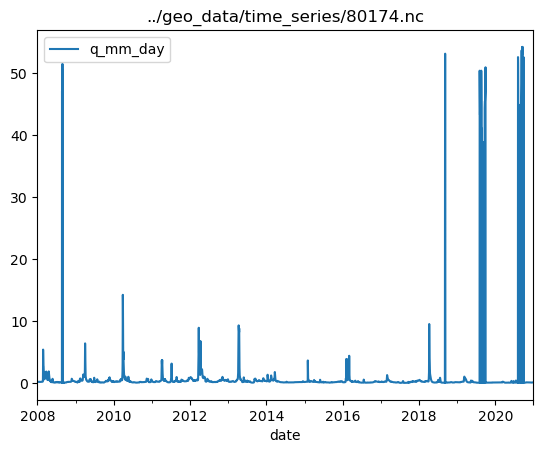

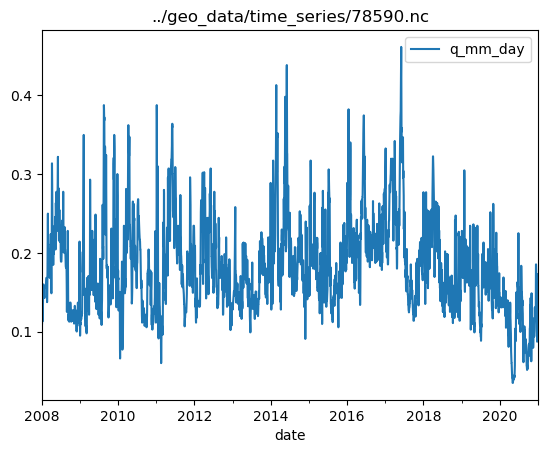

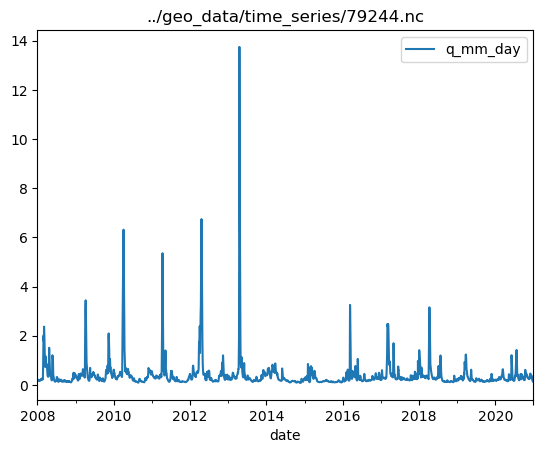

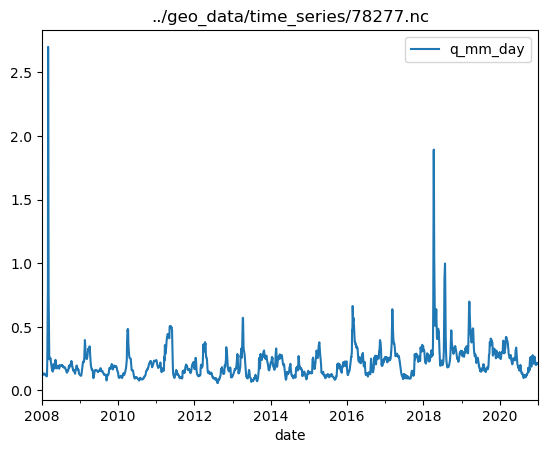

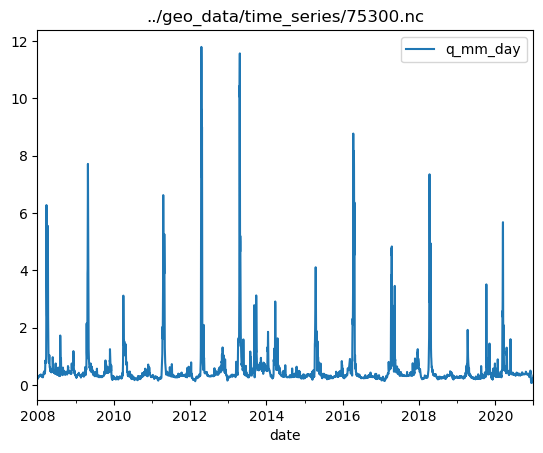

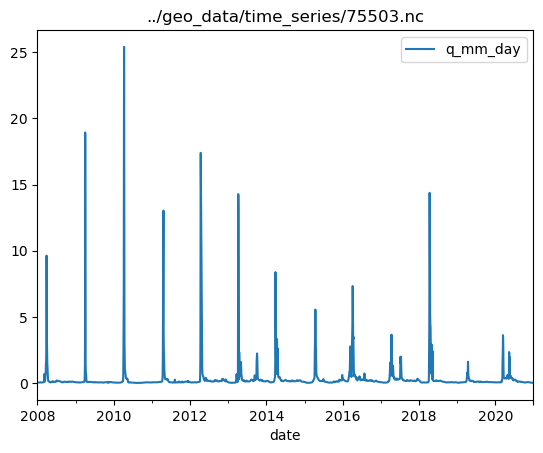

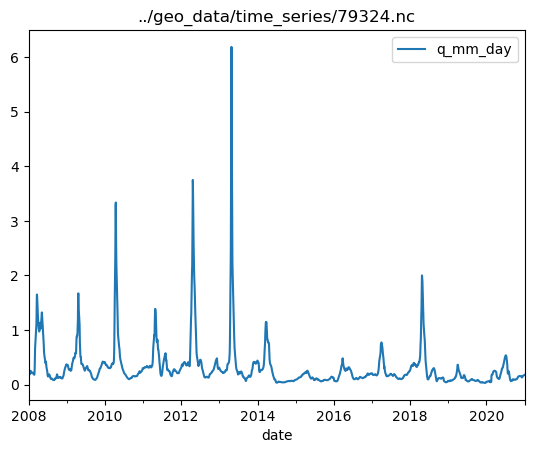

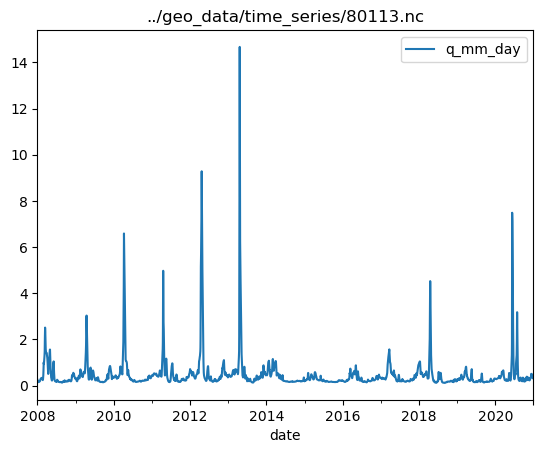

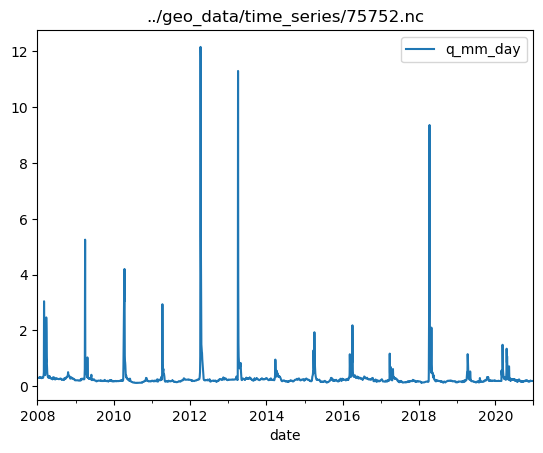

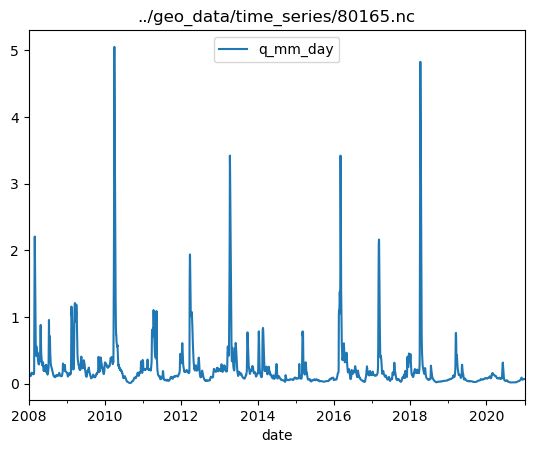

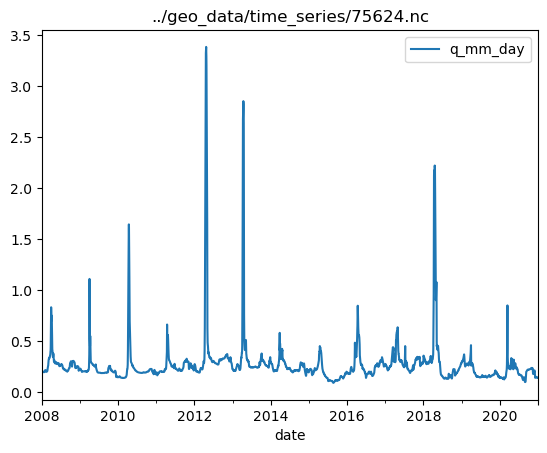

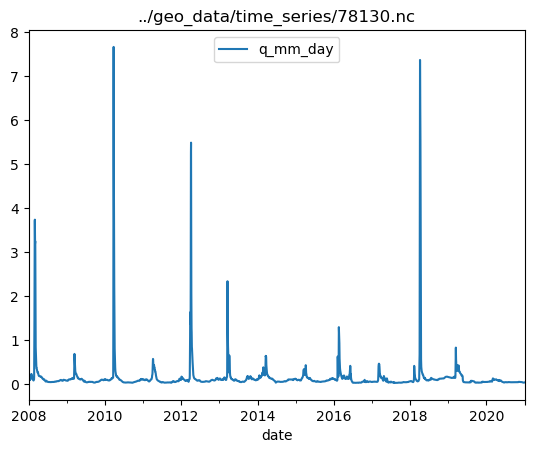

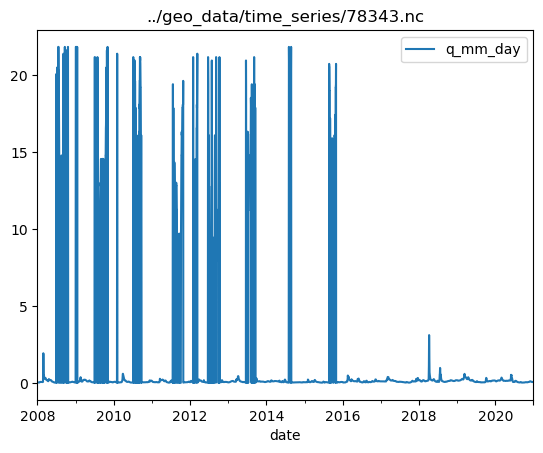

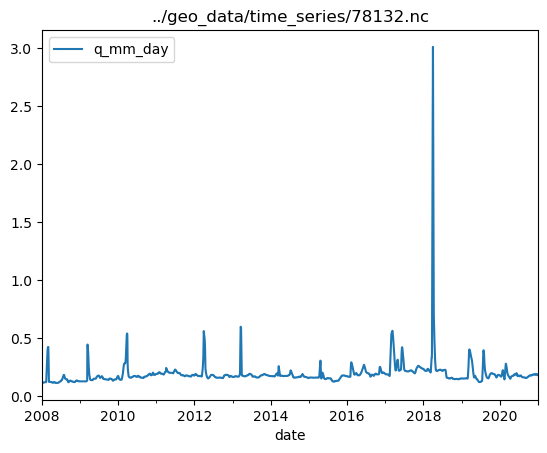

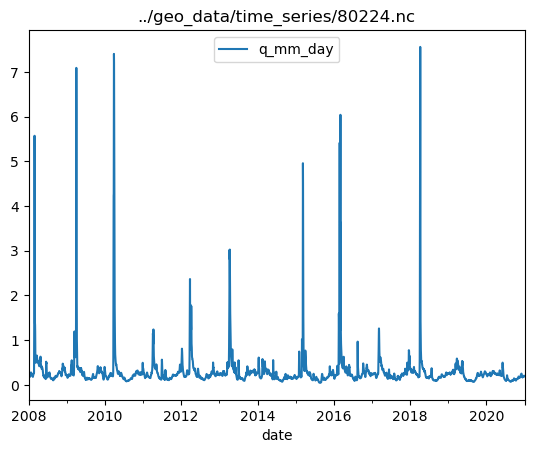

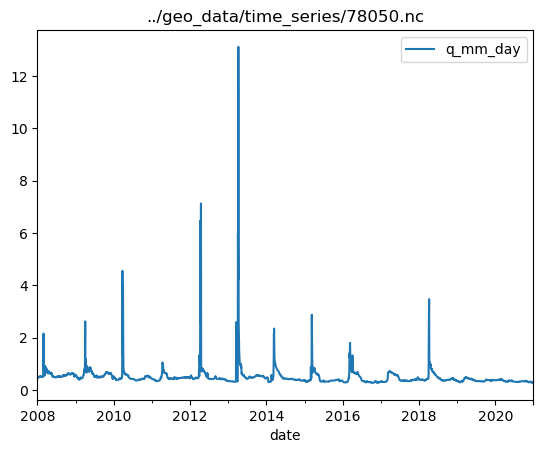

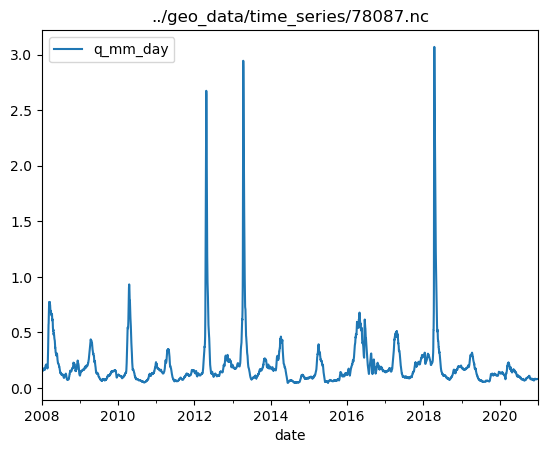

In [18]:
for file in glob.glob(f'{ts_dir}/*.nc'):
    df = xr.open_dataset(file).to_dataframe()
    my_plot = df[['q_mm_day']].plot();
    
    my_plot.set_title(f'{file}')

In [9]:
df

,lvl_sm,q_cms_s,lvl_mbs,q_mm_day,t_max_e5l,t_max_e5,t_min_e5l,t_min_e5,prcp_e5l,prcp_e5,...,Eb,Es,Et,SMsurf,SMroot,Ew,Ei,S,E,Ep
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,122.0,19.40,825.86,0.502573,-11.268421,-11.366631,-17.111842,-18.210788,2.832099,1.466107,...,-0.004070,0.0,0.058561,0.366866,0.359051,0.001062,0.023925,0.974593,0.079478,0.080023
2008-01-02,121.0,18.80,825.85,0.487030,-11.997806,-12.166376,-17.141311,-17.583211,0.633187,0.720303,...,-0.004893,0.0,0.047173,0.369573,0.359499,0.001072,0.079571,0.975225,0.122923,0.123251
2008-01-03,122.0,19.40,825.86,0.502573,-11.473903,-12.413093,-16.847722,-18.704398,0.264636,0.150389,...,-0.007245,0.0,0.041296,0.365999,0.359256,0.001071,0.014072,0.982568,0.049194,0.049229
2008-01-04,121.0,18.80,825.85,0.487030,-10.814420,-11.557410,-15.799435,-16.768878,0.723090,0.685173,...,-0.000495,0.0,0.078455,0.374734,0.360570,0.001168,0.100057,0.983480,0.179185,0.179185
2008-01-05,120.0,18.20,825.84,0.471486,-12.508568,-12.702437,-19.522611,-20.592123,0.914933,0.619627,...,-0.001805,0.0,0.054510,0.370305,0.360361,0.000858,0.032867,0.975735,0.086430,0.086925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,14.0,8.09,824.78,0.209578,1.388621,0.462721,-6.657382,-9.346828,0.002276,0.000000,...,-0.008634,0.0,0.066691,0.357125,0.351696,0.001822,0.000000,0.948778,0.059879,0.060993
2020-12-28,14.0,8.33,824.78,0.215796,1.033435,0.741358,-6.965816,-9.239318,0.001521,0.000000,...,-0.009026,0.0,0.062287,0.355974,0.351287,0.001813,0.000000,0.963771,0.055074,0.056156
2020-12-29,13.0,8.80,824.77,0.227971,2.353240,1.676279,-7.205751,-9.861136,0.002260,0.000000,...,-0.007134,0.0,0.077782,0.355249,0.350986,0.001780,0.000041,0.957457,0.072469,0.073801


#### Ural

In [12]:
gauges = gpd.read_file(
    '../paper_visualisation/poor_gauges/ural.gpkg')
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_all_q/*.nc')
gauge_list = list()
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(gauges['gauge_id']):
        gauge_list.append(file)
        
# add train
file_rewriter(q_pathes=gauge_list,
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])

if torch.cuda.is_available():
    start_run(config_file=Path("./poor_perfom_configs/era5L_ural_qmm.yml"))
gc.collect()

2023-04-10 06:09:49,184: PROJ: internal_proj_identify: /opt/conda/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
2023-04-10 06:09:50,795: Logging to runs_bad_regions/era5L_ural_1004_060950/output.log initialized.
2023-04-10 06:09:50,796: ### Folder structure created at runs_bad_regions/era5L_ural_1004_060950
2023-04-10 06:09:50,796: ### Run configurations for era5L_ural
2023-04-10 06:09:50,796: experiment_name: era5L_ural
2023-04-10 06:09:50,796: run_dir: runs_bad_regions/era5L_ural_1004_060950
2023-04-10 06:09:50,797: train_basin_file: openf_basins.txt
2023-04-10 06:09:50,797: validation_basin_file: openf_basins.txt
2023-04-10 06:09:50,798: test_basin_file: openf_basins.txt
2023-04-10 06:09:50,798: train_start_date: 2009-01-01 00:00:00
2023-04-10 06:09:50,799: train_end_date: 2016-12-31 00:00:00
2023-04-10 06:09:50,799: validation_start_date: 2017-01-01 00:00:00
2023-04-10 06:09:50,800: validati

28

#### VolgoDon

In [13]:
gauges = gpd.read_file(
    '../paper_visualisation/poor_gauges/volgo_don.gpkg')
# add test
q_pathes = glob.glob('../geo_data/great_db/nc_all_q/*.nc')
gauge_list = list()
for file in q_pathes:
    gauge_id = file.split('/')[-1][:-3]
    if gauge_id in list(gauges['gauge_id']):
        gauge_list.append(file)
        
# add train
file_rewriter(q_pathes=gauge_list,
              ts_dir=ts_dir,
              hydro_target='q_mm_day',
              meteo_predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])

if torch.cuda.is_available():
    start_run(config_file=Path("./poor_perfom_configs/era5L_volgoDon_qmm.yml"))
gc.collect()

2023-04-10 06:18:15,646: PROJ: internal_proj_identify: /opt/conda/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
2023-04-10 06:18:19,207: Logging to runs_bad_regions/era5L_volgoDon_1004_061819/output.log initialized.
2023-04-10 06:18:19,208: ### Folder structure created at runs_bad_regions/era5L_volgoDon_1004_061819
2023-04-10 06:18:19,208: ### Run configurations for era5L_volgoDon
2023-04-10 06:18:19,208: experiment_name: era5L_volgoDon
2023-04-10 06:18:19,209: run_dir: runs_bad_regions/era5L_volgoDon_1004_061819
2023-04-10 06:18:19,209: train_basin_file: openf_basins.txt
2023-04-10 06:18:19,209: validation_basin_file: openf_basins.txt
2023-04-10 06:18:19,210: test_basin_file: openf_basins.txt
2023-04-10 06:18:19,210: train_start_date: 2009-01-01 00:00:00
2023-04-10 06:18:19,210: train_end_date: 2016-12-31 00:00:00
2023-04-10 06:18:19,211: validation_start_date: 2017-01-01 00:00:00
2023-04-10 06

0